# Classifying braking events and no events using MNE 

<br>

<hr>

## Description

This notebook converts the data that have been presented into format readable by the library MNE and tries to classify collison and nocollison event classes using pipelines coming from MNE and sklearn

In [1]:
# Imports
import scipy.io
import h5py
import time
from h5py import File 
import matplotlib.pyplot as plt
import numpy as np
import mne
from mne.channels import make_standard_montage

from sklearn.pipeline import make_pipeline
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

#import matplotlib
#matplotlib.use('Agg')

In [2]:
# Path to raw data
path_data_mat = '/Users/obando_c/Documents/Neuro/EmergencyBraking/Data/Raw/'

# File name of one subject
file_name = "VPja.mat" 

# Path to save process data
#path_postprocess_mat = '/Users/obando_c/Documents/Neuro/EmergencyBraking/data/post_processed/'

## Prepare Data

### Extract data

**cnt**  &emsp; &emsp; &emsp;  &emsp; &emsp; &emsp; &nbsp;  *Structure containing the data of different channels: EEG, EMGf, 'lead_gas', 'lead_brake', 'dist_to_lead', 'wheel_X', 'wheel_Y', 'gas', 'brake'*  <br>
**mnt**  &emsp; &emsp; &emsp;  &emsp; &emsp; &emsp; &nbsp;*Structure defining electrode positions*  <br>
**mrk** &emsp; &emsp; &emsp; &emsp; &emsp; &emsp;  *Structure containing the braking event* <br>
<!--- **cnt.clab**  &emsp; &emsp; &emsp; &emsp;&emsp;*EEG electrodes names* <br> -->   
<!--- **mrk/className**   &emsp; *Names of the different types of events*--> 

In [3]:
start = time.time()
with h5py.File(path_data_mat + file_name, 'r') as f:
    #print("Number of items in ",file_name, ": ", len(list(f)))
    #print("Items inside ",file_name, ": ", list(f.items()))
    cnt = f.get('cnt')
    #print("Items in cnt", list(cnt.items()) )
    #T = np.array(cnt.get('T'))
    clab = np.array(cnt.get('clab')) # clab is the electrode names
    #file = np.array(cnt.get('file'))
    fs = np.array(cnt.get('fs')) # fs is the sampling rate: 200
    #title = np.array(cnt.get('title'))
    x = np.array(cnt.get('x')) # x is the continuous multivariate data
    
end = time.time()
print("Elapsed time:", (end - start), "s")

Elapsed time: 6.453633069992065 s


In [4]:
# Extract name of channels 
f = h5py.File(path_data_mat + file_name,'r') 
test = f['cnt/clab']
name_elec = list()
for j in range(len(test)):
    st = test[j][0]
    obj = f[st]
    str1 = ''.join(chr(i) for i in obj[:])
    name_elec.append(str1)
print("Names of channels:", name_elec)

Names of channels: ['EOGv', 'Fp1', 'Fp2', 'AF3', 'AF4', 'EOGh', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'P9', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'EMGf', 'lead_gas', 'lead_brake', 'dist_to_lead', 'wheel_X', 'wheel_Y', 'gas', 'brake']


In [5]:
# Extract data mrk - contains information on the events
start = time.time()
with h5py.File(path_data_mat + file_name, 'r') as f:
    mrk = f.get('mrk')
    #print("Items in mrk", list(mrk.items()) )
    #className = np.array(mrk.get('className')) # are the names of the different types of events
    event = mrk.get('event') # 
    print("Items in event", list(event.items()) )
    react = np.array(event.get('react'))
    time_mrk = np.array(mrk.get('time')) # mrk.time is the timestamp for each event in milliseconds
    y = np.array(mrk.get('y')) # mrk.y is a binary matrix indicating which of the five types each event is
    
end = time.time()
print("Elapsed time:", (end - start), "s")

Items in event [('react', <HDF5 dataset "react": shape (1, 948), type "<f8">)]
Elapsed time: 0.0029981136322021484 s


In [6]:
# Extract className
f = h5py.File(path_data_mat + file_name,'r') 
test = f['mrk/className']
className = list()
for j in range(len(test)):
    st = test[j][0]
    obj = f[st]
    str1 = ''.join(chr(i) for i in obj[:])
    className.append(str1)
print("Class names:",className)

Class names: ['car_normal', 'car_brake', 'car_hold', 'car_collision', 'react_emg']


### Create braking event variables 

**car_brake**  &emsp; &emsp; &emsp;  &emsp; &emsp; &emsp; &nbsp;  *Times stamp in ms for lead vehicle starts to brake*  <br>
**react_emg**  &emsp; &emsp; &emsp;  &emsp; &emsp; &emsp; &nbsp;*The subject starts to brake. The onset is defined here through the EMG*  <br>
**car_collision** &emsp; &emsp; &emsp; &emsp; &emsp;  *Denotes collisions between driver and lead vehicle* <br>

In [7]:
car_brake = time_mrk.T*y[:,1] # mrk.time is the timestamp for each event in milliseconds
react_emg = time_mrk.T*y[:,4] # mrk.time is the timestamp for each event in milliseconds
car_collision = time_mrk.T*y[:,3]
print("Number of events: ", len(car_brake[car_brake>0]))
print("Number of collision: ", len(car_collision[car_collision>0]))

Number of events:  230
Number of collision:  36


In [8]:
#events = car_brake[car_brake>0]*0.005

### Extract electrodes 2D and 3D positions 

In [8]:
with h5py.File(path_data_mat + file_name, 'r') as f:
    mnt = f.get('mnt')
    #x_pos_allChannels = np.array(mnt.get('x'))
    #y_pos_allChannels = np.array(mnt.get('y'))
    pos3d_allChannels = np.array(mnt.get('pos_3d'))  # coord in 3D 
channels_eeg = np.delete(np.arange(61), [0, 5])
#x_pos = x_pos_allChannels[0][channels_eeg]
#y_pos = y_pos_allChannels[0][channels_eeg]

### Collision Events 

In [9]:
# Find events with collision 
# when comapring car_brake, car_collision, no need to convert with /5
# car_brake_y = car_brake[car_brake>0]
# car_collision_y = car_collision[car_collision>0]
# collison_label = []
# for i in range(len(car_brake_y)):
#     diff = car_collision_y - car_brake_y[i]
#     if ( len(diff[diff>0])==0):
#         collison_label.append(0)
#     elif (min(diff[diff>0]) > 25000): # car_brake_y[i] is too far from any collision, so label = 0, 25000 is
#         collison_label.append(0)
#     else:
#         collison_label.append(1)

In [9]:
events_brr = np.array(car_brake[car_brake>0]/5).astype(float) 

In [10]:
non_events = []
i=0
while i < len(events_brr):
    non_event_temp = np.random.randint(0,x.shape[1])
    if(len(np.where(abs(events_brr - non_event_temp)<=3000)[0])==0):
        non_events.append(non_event_temp)
        i += 1

In [11]:
events_braking = np.empty([len(events_brr)+len(non_events), 3],dtype=int)
events_braking[:len(events_brr),0]=events_brr 
events_braking[len(non_events):,0]=non_events 
events_braking[:,1]=int(0)
events_braking[:len(events_brr),2]=1
events_braking[len(non_events):,2]=0

### Design Montage from 3D electrode positions

In [47]:
# pos3d_eeg = pos3d_allChannels[channels_eeg,:]
# dig_ch_pos = dict(zip(ch_names,pos3d_eeg))
# montage = mne.channels.make_dig_montage(ch_pos=dig_ch_pos,
#                            nasion=[0,0,0])

In [12]:
# Standard Montage
montage_std = make_standard_montage('biosemi64')
#montage_std.plot()
#plt.close()

<br>
<hr>

## Import Emergancy Braking Data into MNE-library format


MNE library is a tool to processe and analyse M/EEG data

### Take only EEG data 

In [13]:
eeg_data = x[channels_eeg,:]
ch_names = np.array(name_elec)[channels_eeg]
ch_types = 'eeg'

In [17]:
### Take all data 
# eeg_data = x[channels_eeg,:]
# ch_names = np.array(name_elec)[channels_eeg]
# ch_types =  np.array(['eeg '] * len(ch_names)).astype(str)
# ch_types[:60] = 'eeg'
# ch_types[0]=ch_types[5]= 'eog'
# ch_types[60] = 'emg'
# ch_types[61:] = 'misc'

In [14]:
info = mne.create_info (ch_names = ch_names.tolist(), sfreq = fs, ch_types = ch_types ) #, ch_types = ch_types)
info.set_montage(montage_std)
info['description'] = 'EEG Emergency Braking Dataset'

## Creat Raw object

In [15]:
raw = mne.io.RawArray (eeg_data, info)
print(raw)

Creating RawArray with float64 data, n_channels=59, n_times=1619951
    Range : 0 ... 1619950 =      0.000 ...  8099.750 secs
Ready.
<RawArray | 59 x 1619951 (8099.8 s), ~729.4 MB, data loaded>


In [40]:
#raw.info['bads'] = ['Fp2']

## Creat Epochs object

In [17]:
event_id = {'driving': 0, 'braking': 1}  # 
# Trials were cut from -0.3 to 1.2 seconds
tmin = -0.3
tmax = 1.2

Picks - maybe pick a subset

In [18]:
picks = mne.pick_types (raw.info, meg=False, eeg=True, eog=False,
                            exclude='bads')

In [19]:
# Read epochs
epochs = mne.Epochs(raw, events_braking, event_id, tmin=tmin, tmax=tmax, proj=True,
                    picks=picks, baseline=(None, 0.2), preload=True,
                    reject=None)

Not setting metadata
Not setting metadata
460 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 460 events and 301 original time points ...


<ipython-input-19-1d91af64c2e8>:4: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  reject=None)


0 bad epochs dropped


## Plots - DON'T RUN

Effective window size : 10.240 (s)


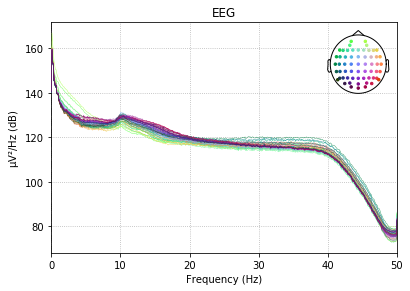

In [127]:
raw.plot_psd(fmax=50,average = False, show =True) # ax=axes[0],
plt.close()

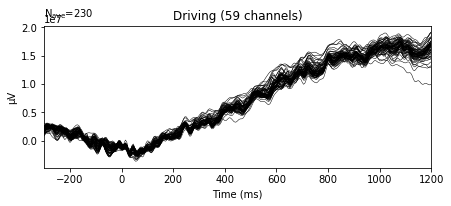

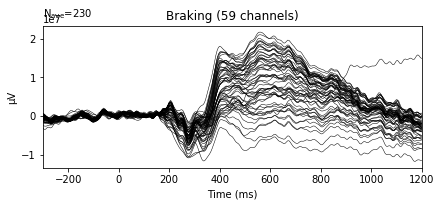

In [134]:
# We can treat the epochs object as we would any other
epochs['driving'].average().plot(time_unit='ms', titles="Driving").savefig("Plots/epochs_driving.png")
epochs['braking'].average().plot(time_unit='ms', titles="Braking").savefig("Plots/epochs_braking.png")

In [114]:
## Plots

{'driving': 0, 'braking': 1}

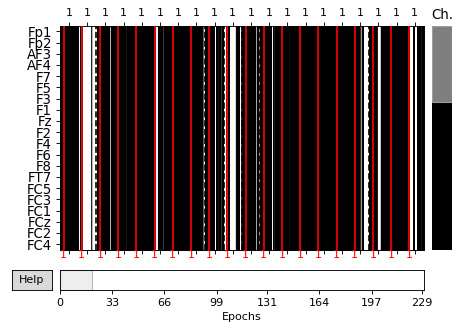

In [123]:
catch_trials_and_buttonpresses = mne.pick_events(events_braking, include=[0,1])
epochs['braking'].plot(events=catch_trials_and_buttonpresses, event_id=event_id,
                    event_colors=dict(braking='red', driving='blue'))
plt.close()

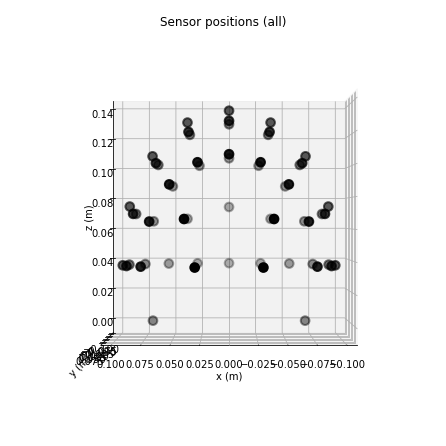

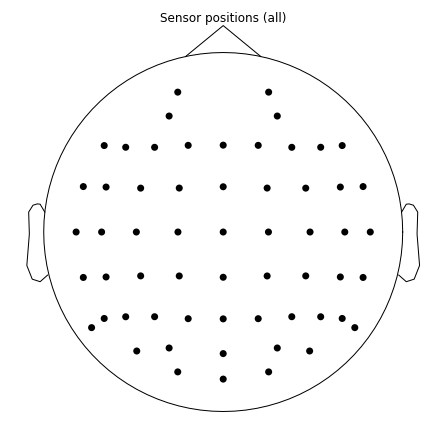

In [124]:
epochs.plot_sensors(kind='3d', ch_type='all')
epochs.plot_sensors(kind='topomap', ch_type='all')
plt.close()

    Using multitaper spectrum estimation with 7 DPSS windows


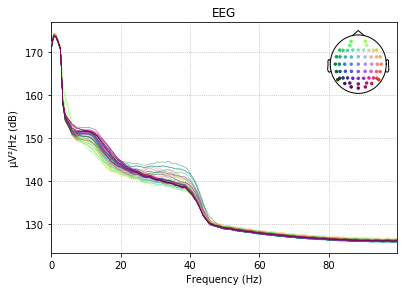

In [126]:
epochs['driving'].plot_psd(picks='eeg')
plt.close()

    Using multitaper spectrum estimation with 7 DPSS windows


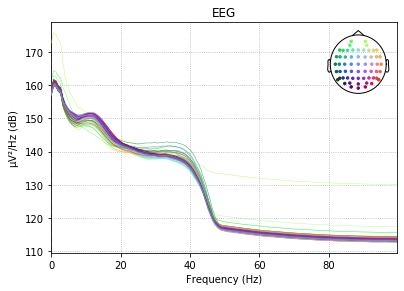

In [121]:
epochs['braking'].plot_psd(picks='eeg')
plt.close()

Not setting metadata
Not setting metadata
230 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


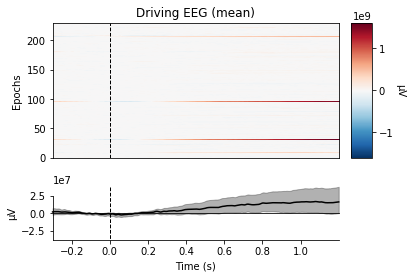

In [193]:
epochs['driving'].plot_image(picks='eeg', combine='mean', title="Driving EEG (mean)")
plt.savefig("Plots/imagemap_epochs_driving.png")

Not setting metadata
Not setting metadata
230 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


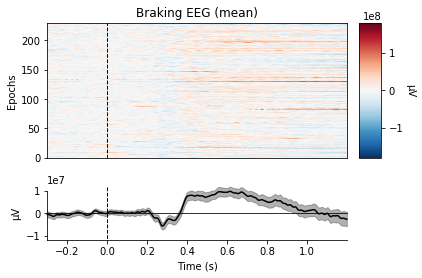

In [191]:
epochs['braking'].plot_image(picks='eeg', combine='mean', title='Braking EEG (mean)')
plt.savefig("Plots/imagemap_epochs_braking.png")

## Decoding (MVPA)

### Add collison event information

In [63]:
# n_brakes = len(events_braking) 
# onset = events_braking[:,0] / raw.info['sfreq']
# duration = np.repeat(0, n_brakes)
# description = np.array(['driving'] * n_brakes)
# description[np.where(np.array(collison_label)==1)]='braking'
# annotations = mne.Annotations(onset, duration, description, orig_time=None)  
# print(annotations)
# raw.set_annotations(annotations)  

<Annotations | 460 segments: braking (36), driving (424)>


In [84]:
# epochs.pick_types(eeg=True,emg=True, exclude='bads')

<Epochs |  460 events (all good), -0.3 - 1.2 sec, baseline [None, 0.1], ~62.5 MB, data loaded,
 'braking': 230
 'driving': 230>

In [20]:
# compute evoked response and noise covariance,and plot evoked
evoked = epochs.average ()
cov = mne.compute_covariance (epochs, tmax=0)

Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 59 dim * 1.2e+10  max singular value)
    Estimated rank (eeg): 59
    EEG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 28060
[done]


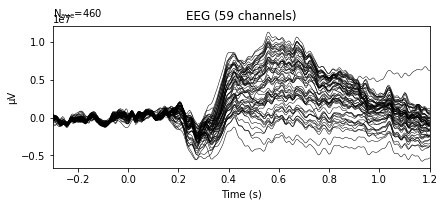

In [21]:
evoked.plot()
plt.close()

In [22]:
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline

In [23]:
X = epochs.get_data()  # EEG signals: n_epochs, n_eeg_channels, n_times
y = epochs.events[:, 2]  # target: Collision Yes or No

In [24]:
X.shape

(460, 59, 301)

### Vectorizer

In [89]:
# # Uses all MEG sensors and time points as separate classification
# # features, so the resulting filters used are spatio-temporal
# clf = make_pipeline(Scaler(epochs.info),
#                     Vectorizer(),
#                     LogisticRegression(solver='lbfgs'))
# 
# scores = cross_val_multiscore(clf, X, y, cv=5, n_jobs=1)
# 
# # Mean scores across cross-validation splits
# score = np.mean(scores, axis=0)
# print('Spatio-temporal: %0.1f%%' % (100 * score,))

Spatio-temporal: 73.5%


In [36]:
# csp = CSP(n_components=3, norm_trace=False)
# clf_csp = make_pipeline(csp, LinearModel(LogisticRegression(solver='lbfgs')))
# scores = cross_val_multiscore(clf_csp, X, y, cv=5, n_jobs=1)
# print('CSP: %0.1f%%' % (100 * scores.mean(),))

Computing rank from data with rank=None
    Using tolerance 2.2e+03 (2.2e-16 eps * 59 dim * 1.7e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.5e+02 (2.2e-16 eps * 59 dim * 3.4e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.


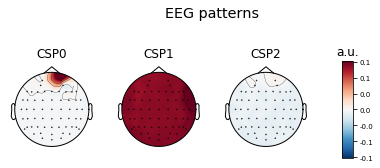

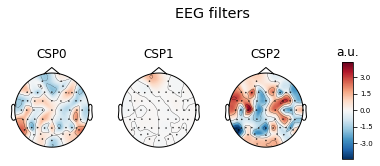

In [91]:
# # Fit CSP on full data and plot
# csp.fit(X, y)
# csp.plot_patterns(epochs.info, scalings=1e-3, title= 'EEG patterns')
# csp.plot_filters(epochs.info, scalings=1e2, title= 'EEG filters')
# plt.close()

### Temporal decoding

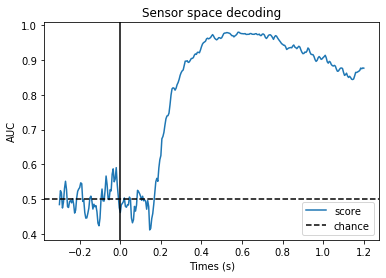

In [25]:
# We will train the classifier on all left visual vs auditory trials on MEG

clf = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs',max_iter=10000))

time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc', verbose=True)
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot
fig, ax = plt.subplots()
ax.plot(epochs.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times (s)')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')
plt.savefig("Plots/decoding_braking_driving.png")
#plt.close()

In [35]:
#raw.set_eeg_reference(projection=True).apply_proj() # I am not sure what it does 

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


<RawArray | 59 x 1619951 (8099.8 s), ~729.4 MB, data loaded>

In [31]:
clf = make_pipeline(StandardScaler(),
                    LinearModel(LogisticRegression(solver='lbfgs',max_iter=10000)))
time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc', verbose=True)
time_decod.fit(X, y)

coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
evoked_time_gen = mne.EvokedArray(coef, epochs.info, tmin=epochs.times[0])
joint_kwargs = dict(ts_args=dict(time_unit='s'),
                    topomap_args=dict(time_unit='s'))
evoked_time_gen.plot_joint(times="peaks", title='patterns',
                           **joint_kwargs)
plt.savefig("Plots/patterns_braking_driving_peaks.png")
plt.close()


No projector specified for this dataset. Please consider the method self.add_proj.


In [34]:
clf = make_pipeline(StandardScaler(),
                    LinearModel(LogisticRegression(solver='lbfgs',max_iter=10000)))
time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc', verbose=True)
time_decod.fit(X, y)

coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
evoked_time_gen = mne.EvokedArray(coef, epochs.info, tmin=epochs.times[0])
joint_kwargs = dict(ts_args=dict(time_unit='s'),
                    topomap_args=dict(time_unit='s'))
evoked_time_gen.plot_joint(times=np.arange(0., 1.200, .200), title='patterns',
                           **joint_kwargs)
plt.savefig("Plots/patterns_braking_driving_0.2s.png")
plt.close()


No projector specified for this dataset. Please consider the method self.add_proj.



No projector specified for this dataset. Please consider the method self.add_proj.


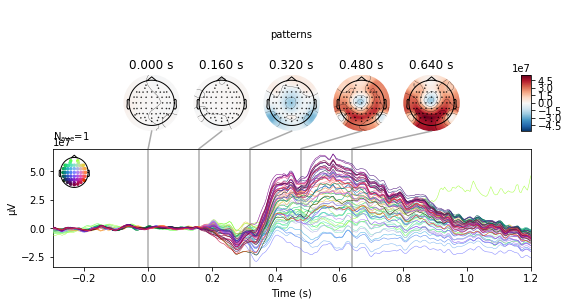

In [26]:
clf = make_pipeline(StandardScaler(),
                    LinearModel(LogisticRegression(solver='lbfgs',max_iter=10000)))
time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc', verbose=True)
time_decod.fit(X, y)

coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
evoked_time_gen = mne.EvokedArray(coef, epochs.info, tmin=epochs.times[0])
joint_kwargs = dict(ts_args=dict(time_unit='s'),
                    topomap_args=dict(time_unit='s'))
evoked_time_gen.plot_joint(times=np.array([0., .160, .320, .480, .640]), title='patterns',
                           **joint_kwargs)
plt.savefig("Plots/patterns_braking_driving_likepaper.png")
plt.close()

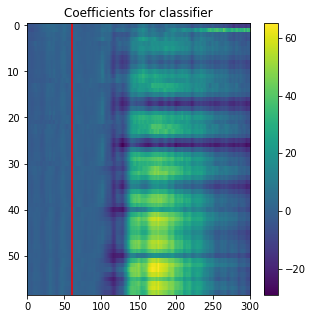

In [37]:
#plt.imshow(coef)
plt.figure(figsize=(5,5))
plt.imshow(coef,aspect='auto')
plt.axvline(x=60, color='red', linestyle='-')
plt.title('Coefficients for classifier')
plt.colorbar()

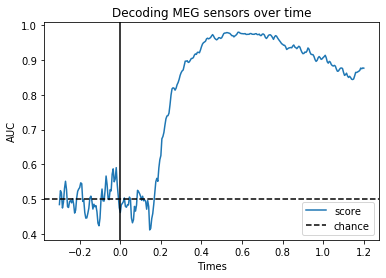

In [28]:
# define the Temporal generalization object
time_gen = GeneralizingEstimator(clf, n_jobs=1, scoring='roc_auc',
                                 verbose=True)

scores = cross_val_multiscore(time_gen, X, y, cv=5, n_jobs=1)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot the diagonal (it's exactly the same as the time-by-time decoding above)
fig, ax = plt.subplots()
ax.plot(epochs.times, np.diag(scores), label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Decoding MEG sensors over time')
plt.savefig("Plots/temporalGen_braking_driving.png")

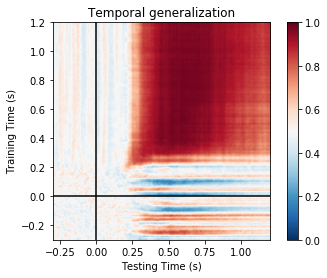

In [29]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(scores, interpolation='lanczos', origin='lower', cmap='RdBu_r',
               extent=epochs.times[[0, -1, 0, -1]], vmin=0., vmax=1.)
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Temporal generalization')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
plt.colorbar(im, ax=ax)
plt.savefig("Plots/temporalGenMatrix_braking_driving.png")

# Miscellaneous 

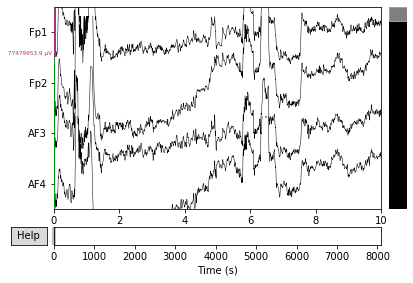

In [120]:
# It is also possible to auto-compute scalings
scalings = 'auto'  # Could also pass a dictionary with some value == 'auto'
raw.plot(n_channels=4, scalings=scalings, title='Auto-scaled Data from arrays',
         show=True, block=True)
plt.close()

### Example of how to use CSD

Fitted sphere radius:         1000.0 mm
Origin head coordinates:      -0.0 -0.0 -0.0 mm
Origin device coordinates:    -0.0 -0.0 -0.0 mm
No projector specified for this dataset. Please consider the method self.add_proj.


<ipython-input-34-7f3444dac7c0>:5: RuntimeWarning: Estimated head size (1000.0 mm) exceeded 99th percentile for adult head size
  evoked_csd = mne.preprocessing.compute_current_source_density(evoked)


No projector specified for this dataset. Please consider the method self.add_proj.


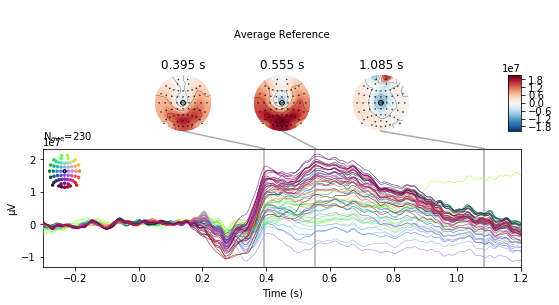

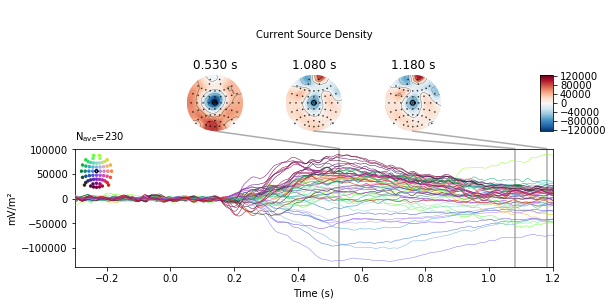

In [34]:
# CSD takes the spatial Laplacian of the sensor signal (derivative in both x and y). 
# It does what a planar gradiometer does in MEG. Computing these spatial derivatives reduces point spread. 
# CSD transformed data have a sharper or more distinct topography, reducing the negative impact of volume conduction.
times = np.array([-0.1, 0., 0.05, 0.1, 0.15])
evoked_csd = mne.preprocessing.compute_current_source_density(evoked)
evoked.plot_joint(title='Average Reference', show=False)
evoked_csd.plot_joint(title='Current Source Density')
plt.close()

Fitted sphere radius:         95.0 mm
Origin head coordinates:      -0.0 -0.0 40.1 mm
Origin device coordinates:    -0.0 -0.0 40.1 mm
No projector specified for this dataset. Please consider the method self.add_proj.
No projector specified for this dataset. Please consider the method self.add_proj.


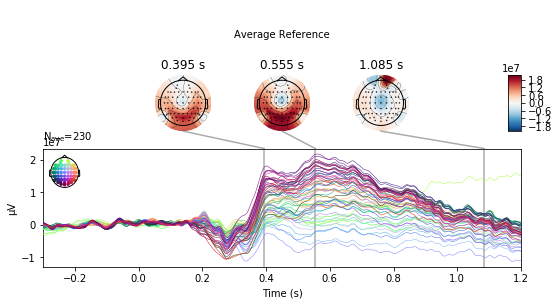

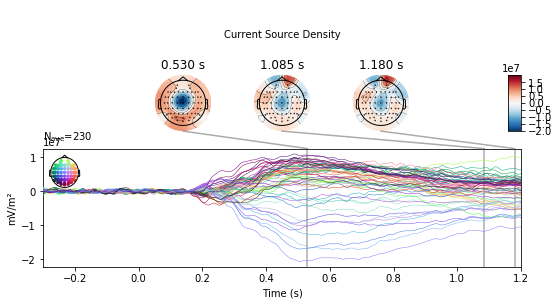

In [195]:
# CSD takes the spatial Laplacian of the sensor signal (derivative in both x and y). 
# It does what a planar gradiometer does in MEG. Computing these spatial derivatives reduces point spread. 
# CSD transformed data have a sharper or more distinct topography, reducing the negative impact of volume conduction.
times = np.array([-0.1, 0., 0.05, 0.1, 0.15])
evoked_csd = mne.preprocessing.compute_current_source_density(evoked)
evoked.plot_joint(title='Average Reference', show=False)
evoked_csd.plot_joint(title='Current Source Density')
plt.close()

### set up and fit the ICA

Fitting ICA to data using 59 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 20 components
Fitting ICA took 35.4s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
4049 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
4049 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


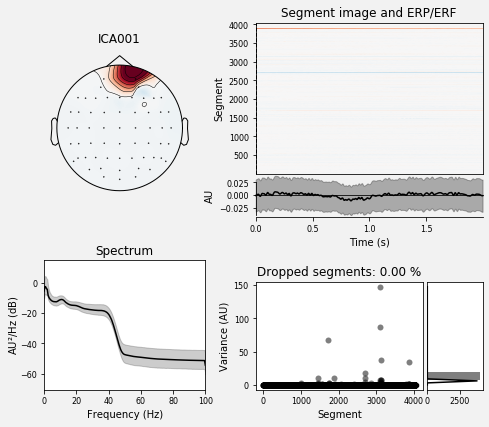

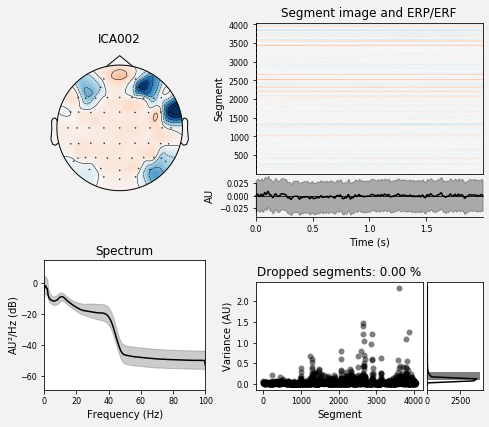

[<Figure size 504x432 with 6 Axes>, <Figure size 504x432 with 6 Axes>]

In [196]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)
ica.exclude = [1, 2]  # details on how we picked these are omitted here
ica.plot_properties(raw, picks=ica.exclude)